In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
# The dataset contains 1 minute OHLCV data from 22 Jun 2019 to 01 Mar 2025 (2,991,782 records)
file_path = "..\data\ALGOUSDT.csv"
df = pd.read_csv(file_path, sep="|", header=None)
print(len(df))

2991782


In [3]:
# set column names
df.columns = ["timestamp", "open", "high", "low", "close", "volume", "Taker Buy Quote Asset Volume", 
                                              "Taker Buy Base Asset Volume", "Quote Asset Volume", "Number of trades"]
# convert unix timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', origin='unix')

# set timestamp as index
df = df.set_index("timestamp")

# sort by index
df = df.sort_index()

# display the first five rows
df.head()

,open,high,low,close,volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,Quote Asset Volume,Number of trades
timestamp,,,,,,,,,
2019-06-22 00:00:00,3.400,3.440,2.989,3.150,196437.510,364193.883,113795.250,626516.851,796
2019-06-22 00:01:00,3.150,3.151,3.019,3.039,157708.607,229296.225,73837.530,487567.859,595
2019-06-22 00:02:00,3.030,3.030,2.875,2.952,145305.629,204476.145,69792.845,426746.227,488
2019-06-22 00:03:00,2.952,2.971,2.893,2.950,95730.841,169035.600,57311.750,281784.965,245
2019-06-22 00:04:00,2.950,2.950,2.880,2.900,47611.763,50610.175,17251.687,138910.063,218


In [8]:
def gen_plot(df, title=None):
    plt.figure(figsize=(12, 3))
    plt.plot(df)
    plt.title(title)
    plt.grid()
    plt.show()

### Check Dataset Completeness

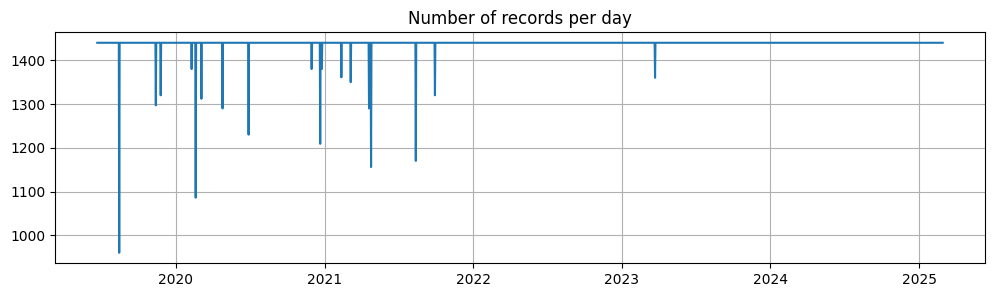

In [ ]:
# Calculate number of records per day
count = df['open'].resample('1D').apply(lambda x: x.count())

# Plot the number of records per day
gen_plot(count, "Number of records per day")

In [ ]:
# Drop 2025-03-01 data
df = df[:'2025-02-28']

In [ ]:
# Find days with incomplete records
incomplete_index = count[count != 1440].index
print(incomplete_index, len(incomplete_index))

DatetimeIndex(['2019-08-15', '2019-11-13', '2019-11-25', '2020-02-09',
               '2020-02-19', '2020-03-04', '2020-04-25', '2020-06-28',
               '2020-11-30', '2020-12-21', '2020-12-25', '2021-02-11',
               '2021-03-06', '2021-04-20', '2021-04-25', '2021-08-13',
               '2021-09-29', '2023-03-24', '2025-03-01'],
              dtype='datetime64[ns]', name='timestamp', freq=None) 19


In [ ]:
# find number of days from 2019-06-22 to 2025-02-28
days = len(pd.date_range(start='2019-06-22', end='2025-02-28', freq='D'))
print(days)

2079


### Imputation

In [4]:
# create a new dataframe for imputed data
df_complete = df.ffill()

# check if there are any missing values
print(df_complete.isnull().sum().sum())

0


### Minute-level close

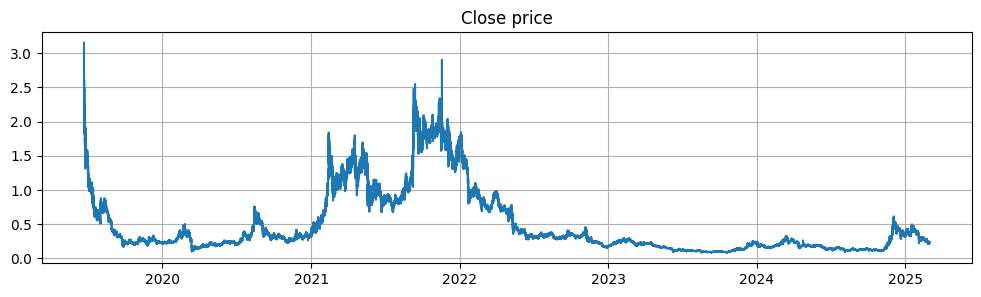

In [ ]:
# Plot close price
gen_plot(df_complete['close'], "Close price")

### Log Return

For $ t = 1, \dots, 2079 $:

$\quad$ For $ n = 1 $:

$$ r_{t,1} = log(p_{t,1}) - log(p_{t-1, 1440}) $$

$\quad$ For $ n = 2, 3, \dots, 1440 $:

$$ r_{t,n} = log(p_{t,n}) - log(p_{t, n-1}) $$

where $p_{t,n}$ is the asset close at the nth minute in time $t$. 

Exception: $r_{1, 1}$ is not defined. 

In [5]:
# construct log return
df_complete['log_return'] = np.log(df_complete['close']).diff()

# check number of missing values 
print(df_complete['log_return'].isnull().sum())

# drop NaN
df_complete = df_complete.dropna()

1


In [ ]:
# plot log return
gen_plot(df_complete['log_return'])

In [ ]:
# find the date where the log return is maximum
max_return_date = df_complete['log_return'].idxmax()
print(max_return_date)

2021-11-18 04:25:00


- the announced addition of an Algorand exchange-traded product (ETP) in Switzerland

### Resampling to Daily Records

$$ r_t = log(p_t) - log(p_{t-1}) $$

$$ RV_t = \sum_{n=1}^{1440} {r_{t, n}^2} $$

$$ lnRV_t = log(\sum_{n=1}^{1440} {r_{t, n}^2}) $$

In [ ]:
# resample to construct a new dataframe for daily OHLC records
df_daily = df_complete.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})

# construct daily (log) return
df_daily['return'] = np.log(df_daily['close']).diff()
df_daily['return2'] = df_daily['return']**2
df_daily.dropna(inplace=True)

# construct daily realised volatility
df_daily['RV'] = df_complete['log_return'].resample('1D').apply(lambda x: np.sum(x**2))

# log transform daily realised volatility
df_daily['lnRV'] = np.log(df_daily['RV'])

# 7, 30 and 60 day average of log transformed daily realised volatility
df_daily['lnRV_lag1'] = df_daily['lnRV'].shift(1)
df_daily['lnRV_5D_lag'] = df_daily['lnRV'].rolling(window=5).mean().shift(1)
df_daily['lnRV_7D_lag'] = df_daily['lnRV'].rolling(window=7).mean().shift(1)
df_daily['lnRV_22D_lag'] = df_daily['lnRV'].rolling(window=22).mean().shift(1)
df_daily['lnRV_30D_lag'] = df_daily['lnRV'].rolling(window=30).mean().shift(1)
df_daily['lnRV_60D_lag'] = df_daily['lnRV'].rolling(window=60).mean().shift(1)

In [ ]:
# drop NaN
df_daily = df_daily.dropna()

### Daily Return and RV plots

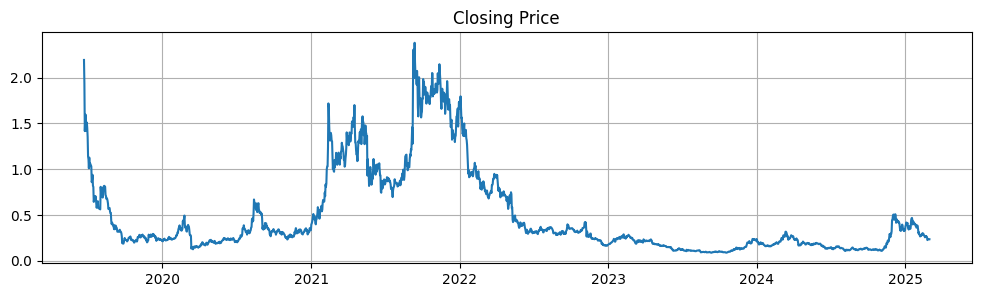

<Figure size 640x480 with 0 Axes>

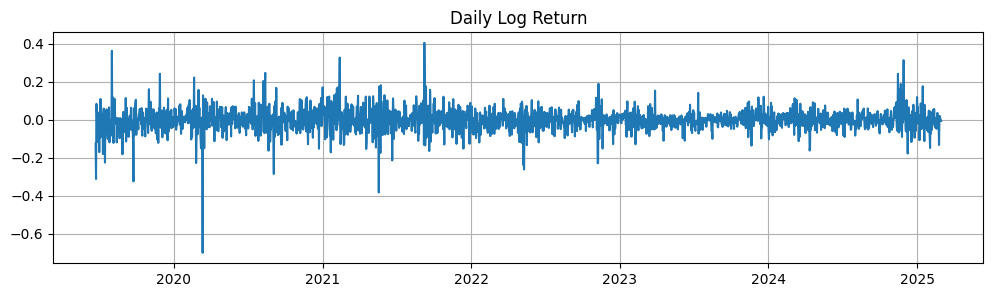

<Figure size 640x480 with 0 Axes>

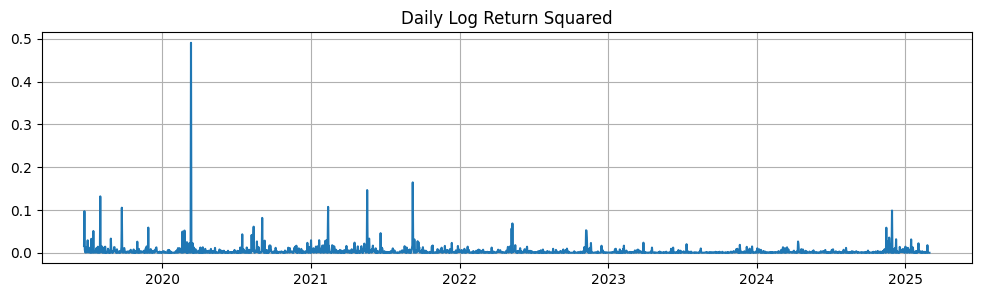

<Figure size 640x480 with 0 Axes>

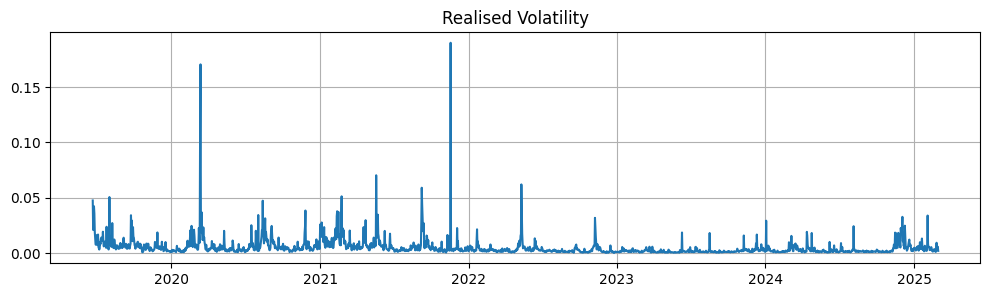

<Figure size 640x480 with 0 Axes>

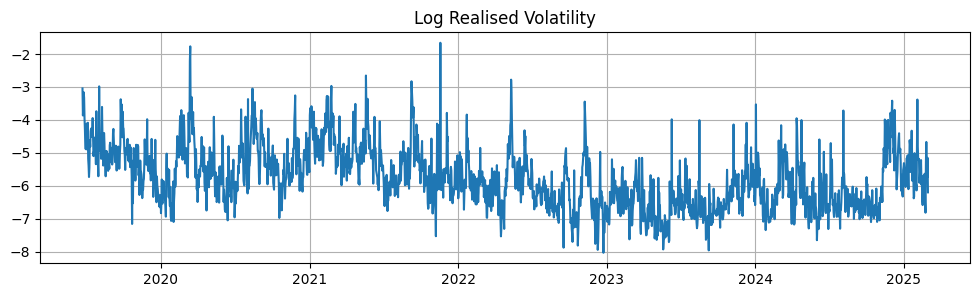

<Figure size 640x480 with 0 Axes>

In [9]:
gen_plot(df_daily['close'], "Closing Price")
plt.savefig('../fig/closing_price.png')
gen_plot(df_daily['return'], "Daily Log Return")
plt.savefig('../fig/daily_log_return.png')
gen_plot(df_daily['return2'], "Daily Log Return Squared")
plt.savefig('../fig/daily_log_return_squared.png')
gen_plot(df_daily['RV'], "Realised Volatility")
plt.savefig('../fig/realised_volatility.png')
gen_plot(df_daily['lnRV'], "Log Realised Volatility")
plt.savefig('../fig/log_realised_volatility.png')

### Summary Statistics

In [11]:
import scipy.stats as stats # type: ignore
from statsmodels.tsa.stattools import adfuller # type: ignore

The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample.

The Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. The test statistic is always nonnegative. If it is far from zero, it signals the data do not have a normal distribution.

In [21]:
df_daily.head()

,open,high,low,close,return,return2,RV,lnRV,lnRV_lag1,lnRV_5D_lag,lnRV_7D_lag,lnRV_22D_lag,lnRV_30D_lag,lnRV_60D_lag
timestamp,,,,,,,,,,,,,,
2019-06-22,3.150,3.151,1.880,2.192,NaN,NaN,0.047570,-3.045562,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.015681,0.020962,-3.865058,-3.045562,NaN,NaN,NaN,NaN,NaN
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.097191,0.025926,-3.652501,-3.865058,NaN,NaN,NaN,NaN,NaN
2019-06-25,1.417,1.920,1.314,1.540,0.083946,0.007047,0.042346,-3.161881,-3.652501,NaN,NaN,NaN,NaN,NaN
2019-06-26,1.538,1.875,1.457,1.595,0.035091,0.001231,0.035729,-3.331801,-3.161881,NaN,NaN,NaN,NaN,NaN


In [13]:
df_daily.columns

Index(['open', 'high', 'low', 'close', 'return', 'return2', 'RV', 'lnRV',
       'lnRV_lag1', 'lnRV_5D_lag', 'lnRV_7D_lag', 'lnRV_22D_lag',
       'lnRV_30D_lag', 'lnRV_60D_lag'],
      dtype='object')

In [14]:
summary_table = pd.DataFrame(index=['mean', 'median', 'std', 'min', 'max', 'skewness', 'kurtosis', 
                                    'ADF', 'ADF p-value', 'JB statistic', 'JB p-value'])

for c in df_daily.columns[:7]:
    summary_table[c] = [df_daily[c].mean(), df_daily[c].median(), df_daily[c].std(),
                        df_daily[c].min(), df_daily[c].max(), df_daily[c].skew(),
                        df_daily[c].kurtosis(), adfuller(df_daily[c])[0], adfuller(df_daily[c])[1], 
                        stats.jarque_bera(df_daily[c]).statistic, stats.jarque_bera(df_daily[c]).pvalue]
print(summary_table.T)
summary_table.T.to_csv('../data/summary_table.csv')

MissingDataError: exog contains inf or nans

### Histogram and QQ-plot of daily log return series

In [89]:
import statsmodels.api as sm

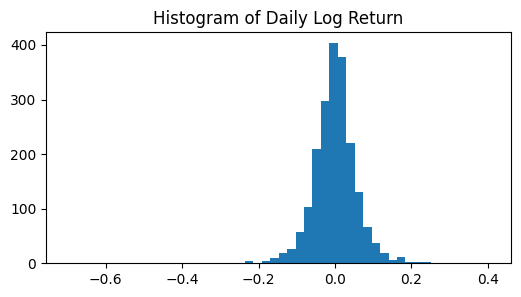

In [90]:
plt.figure(figsize=(6, 3))
plt.hist(df_daily['return'], bins=50)
plt.title('Histogram of Daily Log Return')
plt.show()

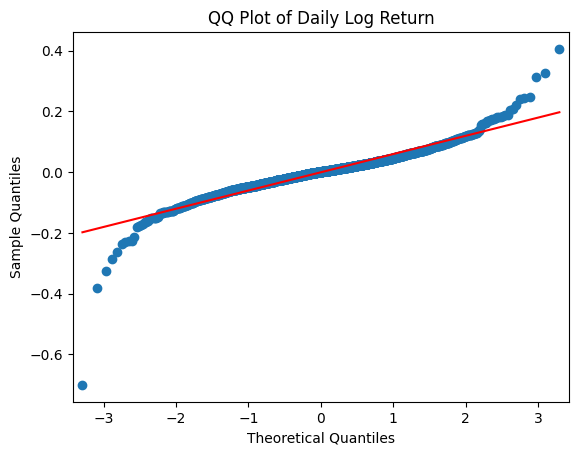

In [91]:
sm.qqplot(df_daily['return'], line ='s')
plt.title('QQ Plot of Daily Log Return')
plt.show()

### Histogram and QQ-plot of daily RV

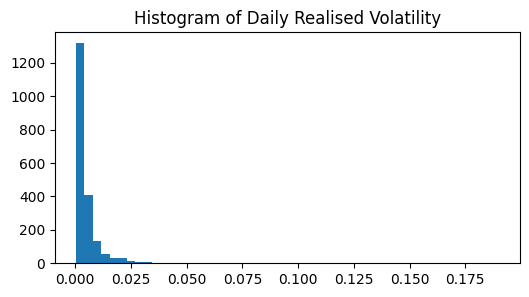

In [92]:
plt.figure(figsize=(6, 3))
plt.hist(df_daily['RV'], bins=50)
plt.title('Histogram of Daily Realised Volatility')
plt.show()

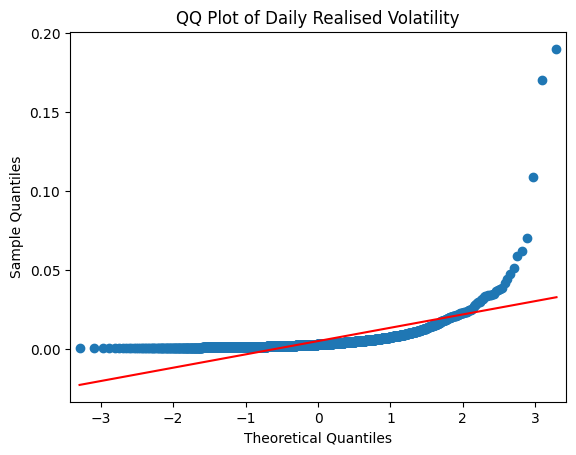

In [93]:
sm.qqplot(df_daily['RV'], line ='s')
plt.title('QQ Plot of Daily Realised Volatility')
plt.show()

### Save pre-processed data

In [23]:
df_daily.to_csv('..\data\ALGO_daily.csv')